# Federated Avg.

Federated Learning proposed by [(McMahan et al., 2016)](https://proceedings.mlr.press/v54/mcmahan17a/mcmahan17a.pdf), where a group of clients train on their own local datasets and transmit parameter updates to a central server.

In FedAVG, each client performs multiple forward-backward passes (epochs over batches), computes the new parameters and then send them to the server for aggregation.
The server updates its parameters to be the average of the parameters of all clients, and then transmits this information to all clients.

In [1]:
import torch
import numpy as np  
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from utils import *

# 1. Downloading MNIST data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(f"Number of training samples: {len(train_dataset)}")

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


# 2. Separating training data to each client

In [17]:
n_clients = 2

# Specify lengths for the splits
lengths = len(train_dataset) // n_clients
splits = [lengths] * n_clients 

# Split the dataset
train_datasets = random_split(train_dataset, splits)
print(f"Number of training samples per client: {[len(dataset) for dataset in train_datasets]}")

# # Now you can create DataLoaders for each subset if needed:
train_loaders = [DataLoader(dataset, batch_size=64, shuffle=True) for dataset in train_datasets]

Number of training samples per client: [30000, 30000]


# 3. Defining architecture that will be used for all participants

In [18]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
            )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.sequential(x)

    def backprop(self, grad_output):
        # Dummy backward pass
        grad_input = torch.autograd.grad(outputs=self.fc.weight, inputs=self.fc.weight, grad_outputs=grad_output)
        return grad_input

# 4. Initializing clients and server

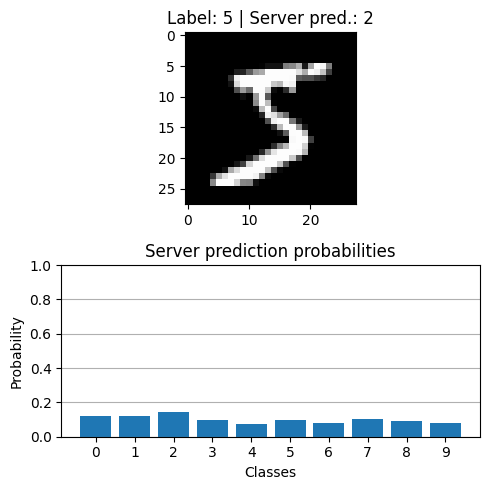

In [26]:
torch.manual_seed(42)

server = Model()
clients = [Model() for _ in range(n_clients)]
copy_global(server, clients) # copying global model to clients

fig, ax = plt.subplots(2, 1, figsize=(5, 5))

image = train_dataset[0][0].unsqueeze(0)  # Get a sample image
label = train_dataset[0][1]  # Get the corresponding
pred = server(image)  # Forward pass through the server model

ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title(f"Label: {label} | Server pred.: {pred.argmax(dim=1).item()}")

ax[1].bar(range(10), torch.nn.functional.softmax(pred.squeeze().detach(), dim=0).numpy())
ax[1].set_title("Server prediction probabilities")      
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Probability")
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(range(10))
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

# 5. Training loop
- each model is trained on a single batch
- the generated param grad is sent to the global model
- the global model runs a simple GD step using the mean of all grads (FedSGD)
- the global params are copied to the clients

In [27]:
n_iters = 10
n_epochs = 1
n_params = len(get_params(server))
lr = 0.1
optimizers = [torch.optim.Adam(client.parameters(), lr=0.01) for client in clients]
loss_func = torch.nn.CrossEntropyLoss()

results = []

for i in tqdm(range(n_iters)):

    copy_global(server, clients)

    params = torch.zeros(n_clients, n_params)

    # Optimizing clients for 1 batch
    for k, client in enumerate(clients):

        client.train()

        for e in range(n_epochs):
            # Get a single batch of data
            for data, target in train_loaders[k]:

                # Batch is fed to the client
                output = client(data)

                # loss is calculated
                loss = loss_func(output, target)

                # loss gradient to each param is calculated
                optimizers[k].zero_grad()
                loss.backward()
                optimizers[k].step()

        # gradients are collected
        params[k] = get_params(client).view(1,-1)

    # Update server parameters
    k = 0
    for j, param in enumerate(server.parameters()):
        param.data = params[:, k:k + param.numel()].mean(dim=0).view(param.shape)
        k = k + param.numel()

    # Evaluate server every K iterations
    if (i+1) % 1 == 0:
        print(f'Iteration {i+1}/{n_iters} | Server eval: {evaluate(server, test_loader)}')

 10%|█         | 1/10 [00:09<01:23,  9.30s/it]

Iteration 1/10 | Server eval: 0.5644


 20%|██        | 2/10 [00:21<01:26, 10.81s/it]

Iteration 2/10 | Server eval: 0.847


 30%|███       | 3/10 [00:34<01:22, 11.85s/it]

Iteration 3/10 | Server eval: 0.8953


 40%|████      | 4/10 [00:43<01:05, 10.86s/it]

Iteration 4/10 | Server eval: 0.9364


 50%|█████     | 5/10 [00:53<00:52, 10.56s/it]

Iteration 5/10 | Server eval: 0.9388


 60%|██████    | 6/10 [01:03<00:41, 10.30s/it]

Iteration 6/10 | Server eval: 0.9425


 70%|███████   | 7/10 [01:15<00:32, 10.77s/it]

Iteration 7/10 | Server eval: 0.9412


 80%|████████  | 8/10 [01:25<00:21, 10.63s/it]

Iteration 8/10 | Server eval: 0.9381


 90%|█████████ | 9/10 [01:34<00:10, 10.06s/it]

Iteration 9/10 | Server eval: 0.9422


100%|██████████| 10/10 [01:43<00:00, 10.39s/it]

Iteration 10/10 | Server eval: 0.9395


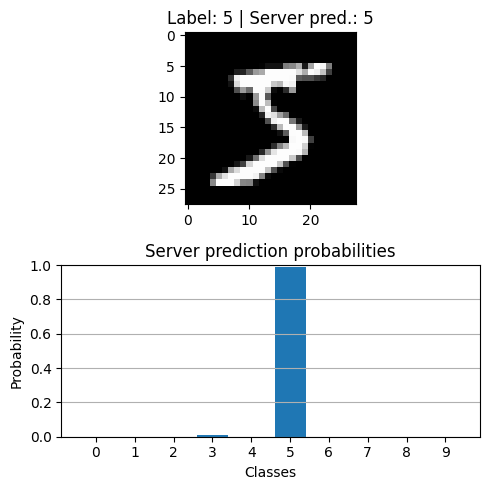

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

image = train_dataset[0][0].unsqueeze(0)  # Get a sample image
label = train_dataset[0][1]  # Get the corresponding
pred = server(image)  # Forward pass through the server model

ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title(f"Label: {label} | Server pred.: {pred.argmax(dim=1).item()}")

ax[1].bar(range(10), torch.nn.functional.softmax(pred.squeeze().detach(), dim=0).numpy())
ax[1].set_title("Server prediction probabilities")      
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Probability")
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(range(10))
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()